In [111]:
import pandas as pd
import numpy as np
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder as le
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [138]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras_contrib.layers import CRF
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import GridSearchCV

In [4]:
top_dir = os.path.join(get_git_root(os.getcwd()))
df_tweets = pd.read_csv(os.path.join(get_git_root(os.getcwd()),"input","labelled_data","tweets_predicted.csv"), lineterminator="\n", index_col=0)

In [5]:
poly_dir = os.path.join(top_dir,"models","poly_users")
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
normal_users = pickle.load(open(os.path.join(poly_dir,"normal_users.pkl"),"rb"))

In [7]:
mono_users = list(set(normal_users) - set(poly_users))

In [9]:
poly_tweets = df_tweets.loc[df_tweets.userID.isin(poly_users)]

In [10]:
mono_tweets = df_tweets.loc[df_tweets.userID.isin(mono_users)]

In [12]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/samarthgoal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samarthgoal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import re
def clean_text(text):
    text = re.sub(r'(#)', "",text) ## removing the hashtags signal 
    text = re.sub(r'(RT \w+:)', "",text) ## remove the retweet info as they dont convey any information
    text = re.sub(r'(author)',"",text)
#     text = re.sub(r'')
    text.rstrip
    text.lstrip
    return(text)

In [13]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [132]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def get_tokens(sentence):
    tokens = tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (tokens)

In [100]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
def clean_tkz(sentence):
    tokens = tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

In [105]:
def get_tokens_length(sentence):
    tokens = tknzr.tokenize(sentence)
    return (len(tokens))

In [18]:
## cleaning the text
poly_tweets["tweetText"] = poly_tweets["tweetText"].apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(clean_text)

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
## tokenizing and lemmatizing
poly_tweets["tweetText"] = (poly_tweets["tweetText"].apply(get_tokens))
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(get_tokens)

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
### sentence level ..
poly_tweets["poly_mono"] = "poly"
mono_tweets["poly_mono"] = "mono"

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
frames = [poly_tweets, mono_tweets]
df_final_tweets = pd.concat(frames)
df_final_sentences = df_final_tweets[['tweetText','poly_mono']]

In [25]:
## tokenize and and get the vocalb
vect_sentence = TfidfVectorizer()

In [20]:
## due to large vocabulary and memory errors using hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer
hashing = HashingVectorizer(n_features=100)

In [50]:
len(df_final_sentences.loc[df_final_sentences.poly_mono == "poly"])

97565

In [51]:
len(df_final_sentences.loc[df_final_sentences.poly_mono == "mono"])

8244

In [27]:
vector = hashing.transform(df_final_sentences["tweetText"])

In [28]:
X = vector.toarray()

In [44]:
X.shape

(105809, 100)

In [33]:
le = le()
le.fit(list(df_final_sentences["poly_mono"]))
y = le.transform(list(df_final_sentences["poly_mono"]))

In [34]:
le.classes_

array(['mono', 'poly'], dtype='<U4')

In [37]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=4)

In [45]:
len(y)

105809

In [39]:
## train test split
X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4 )

In [47]:
Y_test.shape

(21162,)

In [40]:
## Classification
def svm_wrapper(X_train,Y_train):
    param_grid = [
    {'C': [1, 10], 'kernel': ['linear']},
    {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']},]
    svm1 = GridSearchCV(SVC(),param_grid,verbose=4)
    svm1.fit(X_train, Y_train)
    return(svm1)

In [61]:
## random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=40,
                             random_state=0,verbose= 4)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


  Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.43      0.58      1653
           1       0.95      1.00      0.97     19509

   micro avg       0.95      0.95      0.95     21162
   macro avg       0.92      0.71      0.78     21162
weighted avg       0.95      0.95      0.94     21162
 



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished


0.951091579245818

In [54]:
etree = ExtraTreesClassifier(n_estimators=200,verbose=4)
etree.fit(X_train,Y_train)
Y_pred = etree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


  Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.45      0.58      1653
           1       0.96      0.99      0.97     19509

   micro avg       0.95      0.95      0.95     21162
   macro avg       0.89      0.72      0.78     21162
weighted avg       0.94      0.95      0.94     21162
 



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.5s finished


0.949343162271997

In [ ]:
## bilstm --model 
## glove embeddings
# check the max average tweets for each user

In [64]:
len(df_final_tweets.userID.unique())

3177

In [67]:
no_tweets = list()
for user in list(df_final_tweets.userID.unique()):
    tweets =(df_final_tweets.loc[df_final_tweets.userID == user])
    no_tweets.append((user,len(tweets)))
df_user = pd.DataFrame(no_tweets, columns=["userID","len_tweets"])
df_user = df_user.sort_values(by="len_tweets",ascending=True)

In [84]:
users = df_user.userID.unique()
i = 0
users_no = dict()
users_no[0] = 0
## sorted non-decreasing list  
for idx,element in df_user.iterrows():
    if (element["len_tweets"] < (i + 1)):
        users_no[i] += 1 
    else:
        i = i + 1
        users_no[i] = 1

In [85]:
len(users)

3177

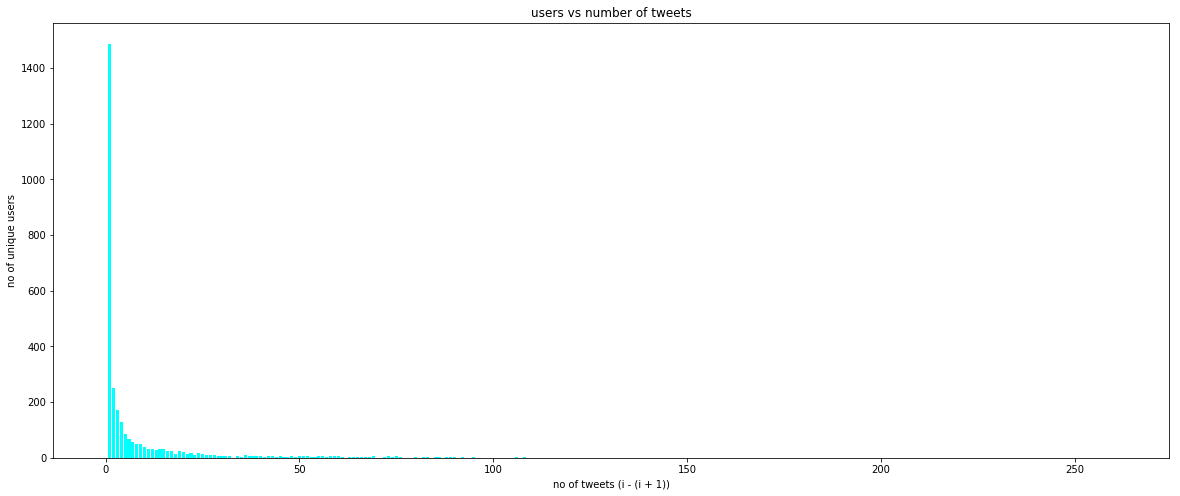

In [93]:
## poly users
plt.figure(figsize= (20,8))
plt.bar(users_no.keys(), users_no.values(), color= "cyan")
plt.xlabel("no of tweets (i - (i + 1))")
plt.ylabel("no of unique users")
plt.title("users vs number of tweets")
plt.show()

In [94]:
## combining all tweets of each user as most of the user have one tweet and there exists at least one tweet fro each user

In [95]:
def get_tweets_user(df):
    df_tweets_comb = list()
    users = df.userID.unique()
    for user in users:
        tweets =(df.loc[df.userID == user])
        tweets_f = (" . ".join(tweets["tweetText"]))
        df_tweets_comb.append((user,tweets_f))
    df_user = pd.DataFrame(df_tweets_comb, columns=["userID","tweetText"])
    return (df_user)

In [97]:
poly_tweets_user = get_tweets_user(poly_tweets)
mono_tweets_user = get_tweets_user(mono_tweets)
poly_tweets_user['label'] = "poly"
mono_tweets_user['label'] = "mono"
frames = [poly_tweets_user, mono_tweets_user]
df_concat_tweets = pd.concat(frames)

In [107]:
tweet_legth_poly = list(poly_tweets_user["tweetText"].apply(clean_tkz))      

In [115]:
tweet_legth_mono = list(mono_tweets_user["tweetText"].apply(clean_tkz))      

In [127]:
tweet_legth_gen = list(df_concat_tweets["tweetText"].apply(clean_tkz))      

In [129]:
print("median_legth_combined",np.median(tweet_legth_gen))
print("avg legth of combines ", np.mean(tweet_legth_gen))

median_legth_combined 19.0
avg legth of combines  407.07711677683346


In [114]:
print("median_legth_poly",np.median(tweet_legth_poly))
print("avg legth of poly ", np.mean(tweet_legth_poly))

median_legth_poly 246.0
avg legth of poly  1228.1542390194077


In [116]:
print("median_legth_mono",np.median(tweet_legth_mono))
print("avg legth of mono ", np.mean(tweet_legth_mono))

median_legth_mono 10.0
avg legth of mono  41.36533212010919


In [98]:
len(df_concat_tweets)

3177

In [123]:
## so well padd and encode sentences to be of fixed length
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [124]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [126]:
word2vec = get_word2vec(os.path.join(embeddings_dir,embedding_file))

MemoryError: 

In [ ]:
token_list = list(df_concat_tweets['tweetText'].apply(get_tokens))

In [134]:
## tokenize
# prepare the input: pad and fit
# prepare tokenizer
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(token_list)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(token_list)
# pad documents to a max length of 4 words
max_len = 15

In [142]:
vocab_size

50696

In [139]:
X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [140]:
X.shape

(3177, 15)

In [133]:
y = (list(df_concat_tweets['label']))
le.fit(y)
y = le.transform(y)
le.classes_

array(['mono', 'poly'], dtype='<U4')

In [141]:
## train test split
X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4 )

In [147]:
## get the embedding matrix weights:
from numpy import zeros
embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: name 'word2vec' is not defined

In [ ]:
max_len= 15
Dimension = 300
input = Input(shape=(max_len,))
model = Embedding(vocab_size,Dimension,weights=[embedding_matrix],input_length=max_len)(input)
model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
model = TimeDistributed(Dense(100,activation='relu'))(model)
model = Flatten()(model)
model = Dense(100,activation='relu')(model)
output = Dense(2,activation='softmax')(model)

In [ ]:
model = Model(input,output)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
## pass the training data
model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = 10, verbose = 4)

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')